In [49]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

random.seed(42)

In [50]:
df = pd.read_csv('train_regr.csv', index_col='id')

df.head()
df = df.dropna()

In [51]:
#ИСпользуем предобработку как для линейной регрессии
df.columns = df.columns.str.replace(' ', '_').str.lower() #Переименовываем колонки для более удобной работы

df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])   #Преобразуем в формат даты
df['year'] = df['policy_start_date'].dt.year #Создаем числовую колонку с годом и месяцем
df['month'] = df['policy_start_date'].dt.month 

df['annual_income'] = np.log1p(df['annual_income']) #Логарифмируем чтобы приблизить к нормальному распределению


df['previous_claims'] = df['previous_claims'].dropna()

#Создаем новые фичи

df['claim_frequency'] = df['previous_claims'] / df['insurance_duration']
df['policy_ratio'] = df['insurance_duration'] / df['age']
df['credit_health'] = df['credit_score'] * df['health_score']
df['credit_health_interaction'] = df['credit_score'] * df['health_score']
df['claims_to_income_ratio'] = (df['previous_claims'] / df['annual_income']) * 10000
df['dependents_income'] = (df['number_of_dependents'] / df['annual_income']) * 10000



In [52]:
df.isna().sum()

age                          0
gender                       0
annual_income                0
marital_status               0
number_of_dependents         0
education_level              0
occupation                   0
health_score                 0
location                     0
policy_type                  0
previous_claims              0
vehicle_age                  0
credit_score                 0
insurance_duration           0
policy_start_date            0
customer_feedback            0
smoking_status               0
exercise_frequency           0
property_type                0
premium_amount               0
year                         0
month                        0
claim_frequency              0
policy_ratio                 0
credit_health                0
credit_health_interaction    0
claims_to_income_ratio       0
dependents_income            0
dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   age                        384004 non-null  float64       
 1   gender                     384004 non-null  object        
 2   annual_income              384004 non-null  float64       
 3   marital_status             384004 non-null  object        
 4   number_of_dependents       384004 non-null  float64       
 5   education_level            384004 non-null  object        
 6   occupation                 384004 non-null  object        
 7   health_score               384004 non-null  float64       
 8   location                   384004 non-null  object        
 9   policy_type                384004 non-null  object        
 10  previous_claims            384004 non-null  float64       
 11  vehicle_age                384004 non-null  float64     

In [54]:
y = df['premium_amount']

# Разделение данных на обучающую и тестовую выборки с сохранением распределения
train_df, test_df, train_target, test_target = train_test_split(df, y, test_size=0.9, random_state=42)

In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38400 entries, 99874 to 381275
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   age                        38400 non-null  float64       
 1   gender                     38400 non-null  object        
 2   annual_income              38400 non-null  float64       
 3   marital_status             38400 non-null  object        
 4   number_of_dependents       38400 non-null  float64       
 5   education_level            38400 non-null  object        
 6   occupation                 38400 non-null  object        
 7   health_score               38400 non-null  float64       
 8   location                   38400 non-null  object        
 9   policy_type                38400 non-null  object        
 10  previous_claims            38400 non-null  float64       
 11  vehicle_age                38400 non-null  float64       
 12  cred

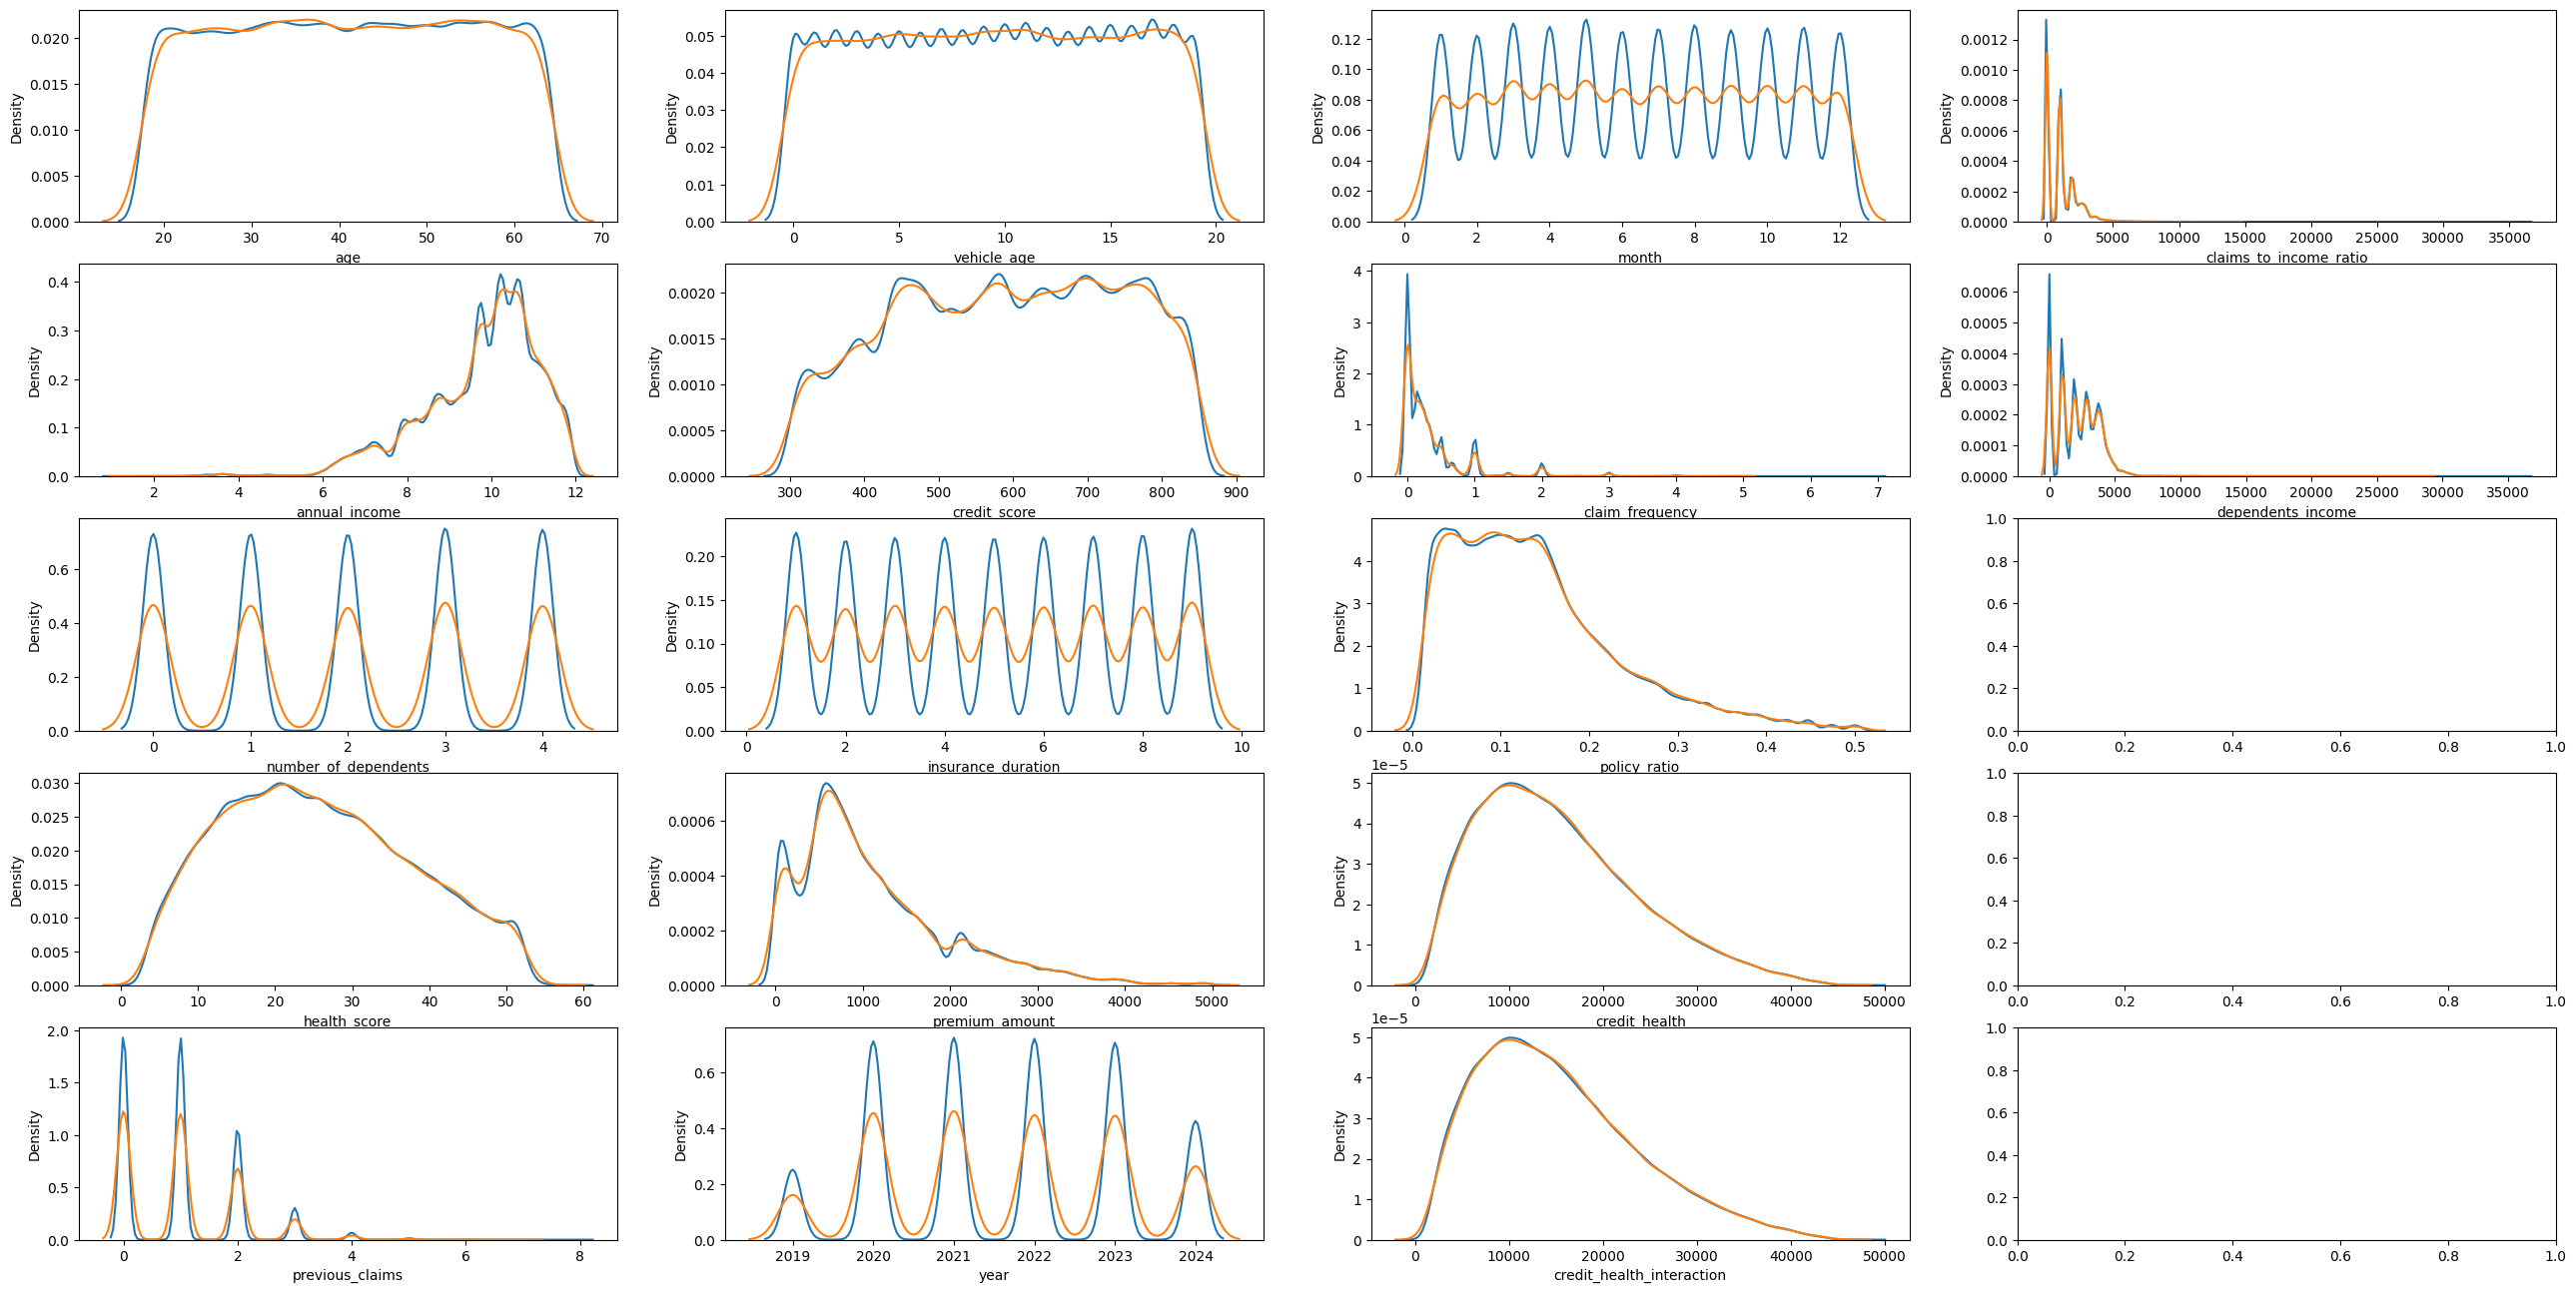

In [56]:
#Сравним распределение фичей в основном датасете и подвыборке

df_num = df.select_dtypes(include=np.number)
df_num_subsample = train_df.select_dtypes(include=np.number)

features = list(df_num.columns)
fig, axes = plt.subplots(5, len(features) // 5 + 1, figsize=(32, 16))

for idx, col in enumerate(features):
    sns.kdeplot(data=df_num, x=col, ax=axes[idx % 5, idx // 5])
    sns.kdeplot(data=df_num_subsample, x=col, ax=axes[idx % 5, idx // 5])


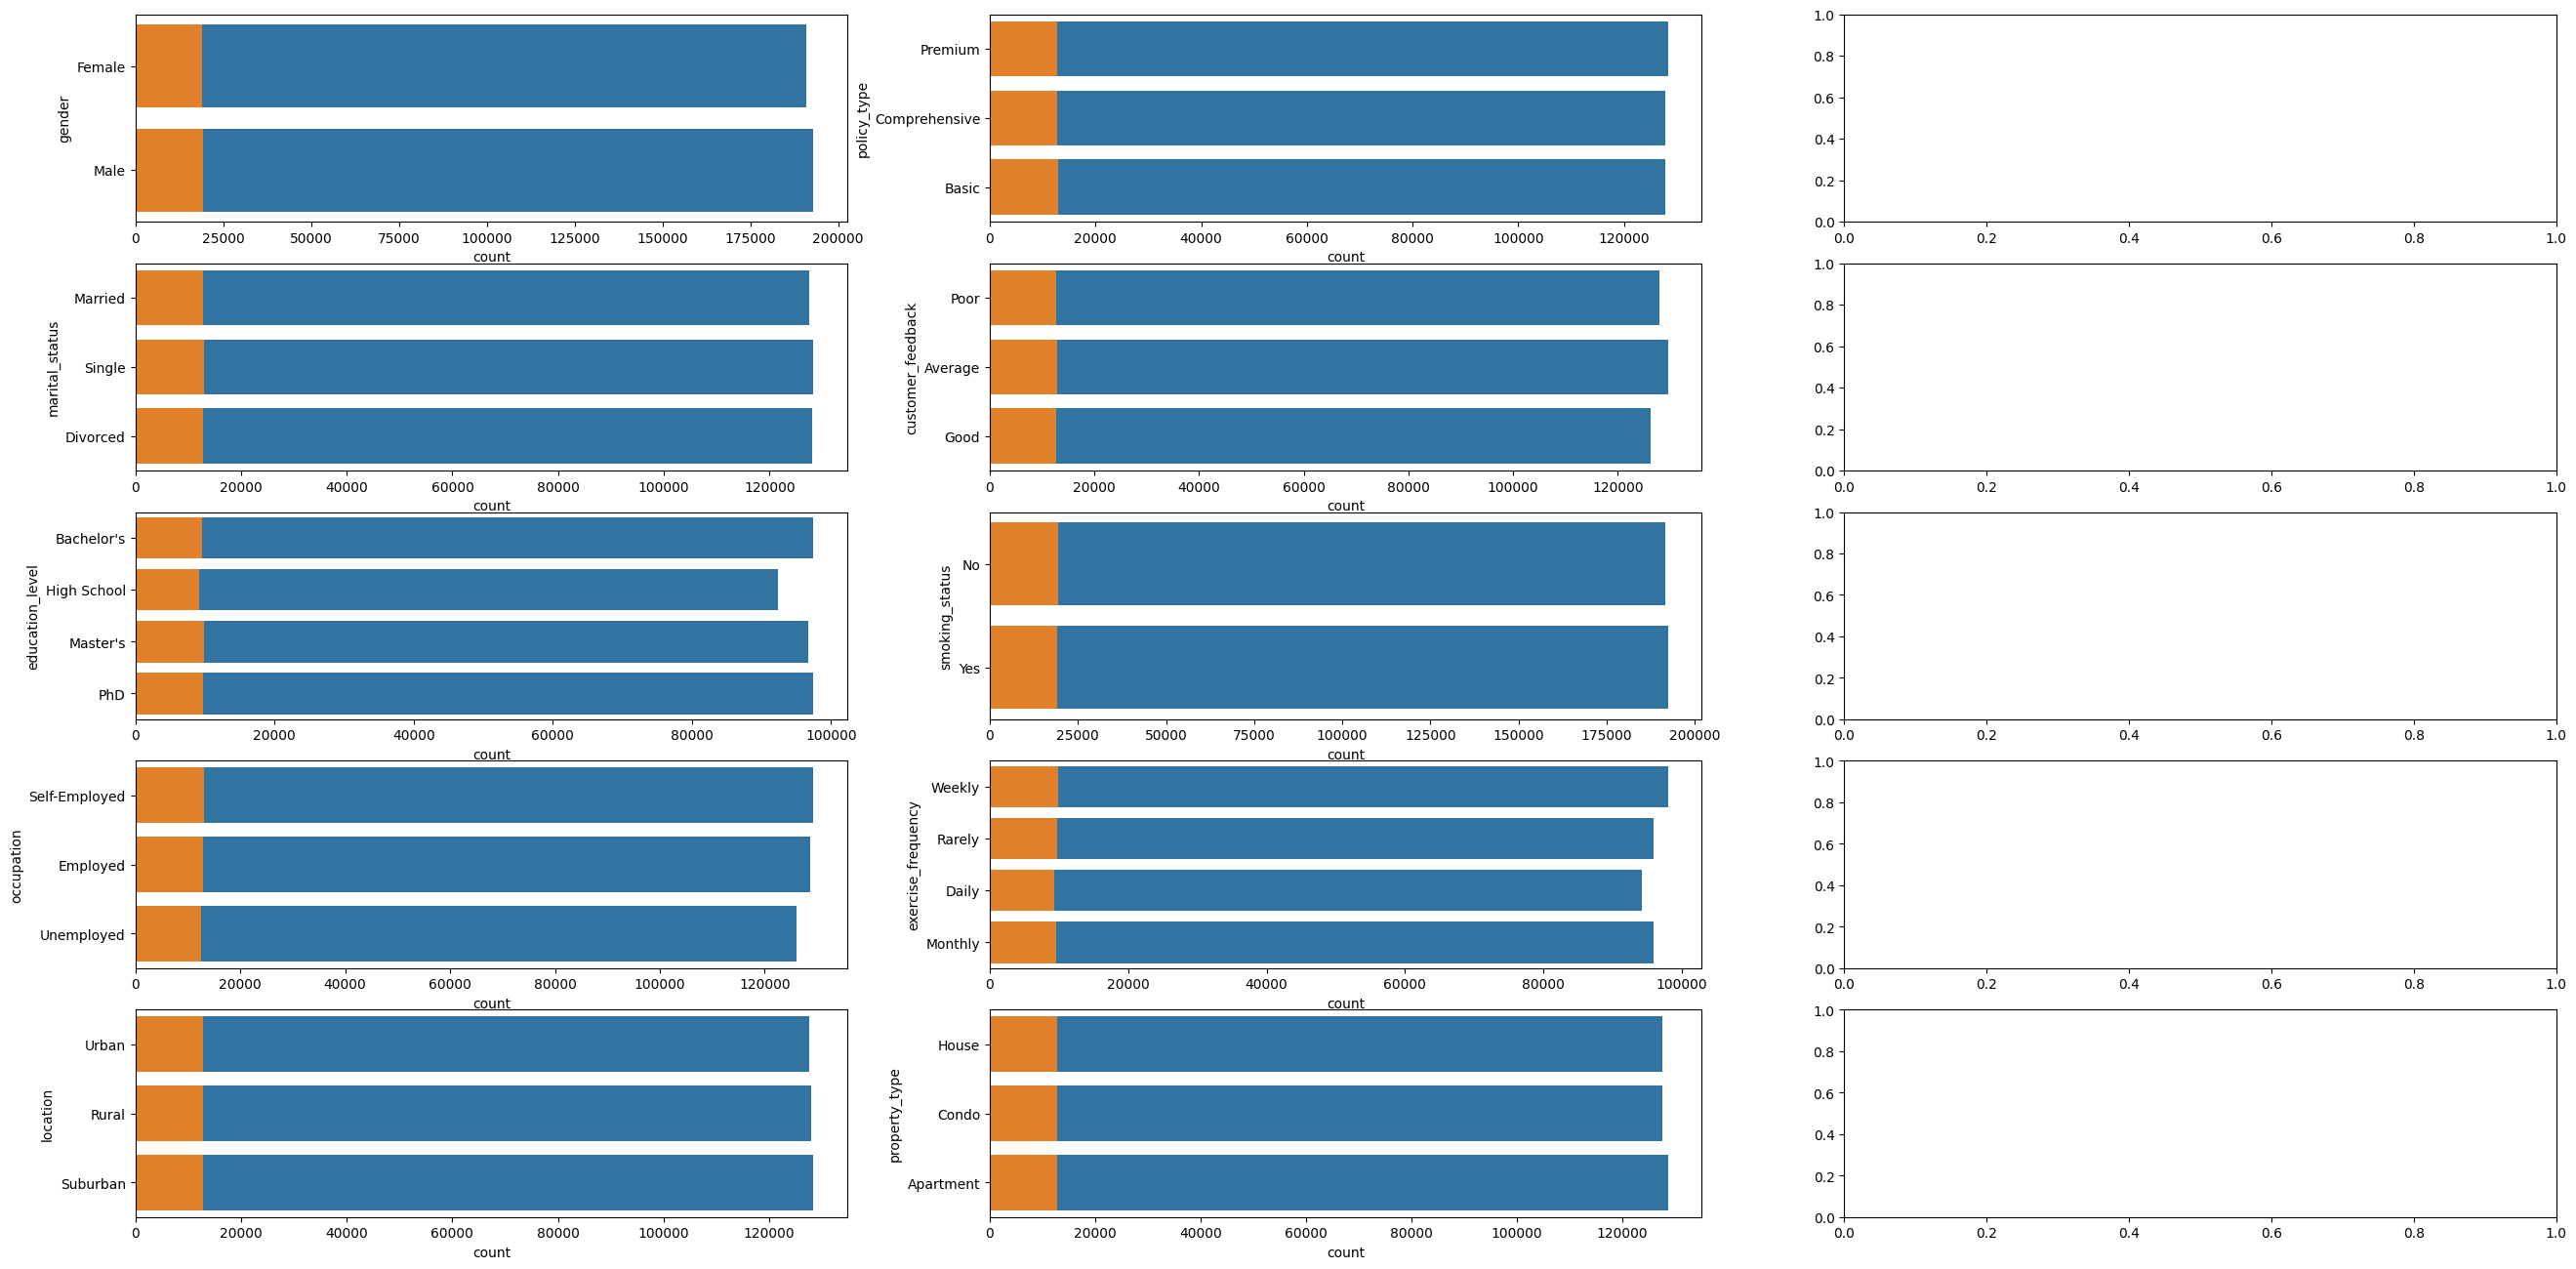

In [57]:
categorial = df.select_dtypes(include=np.object_).columns.to_list()

#Построим распределение категориальных признаков
fig, axes = plt.subplots(5, len(categorial) // 5 + 1, figsize=(32, 16))

for idx, col in enumerate(categorial):
    sns.countplot(data=df[col].dropna(), ax=axes[idx % 5, idx // 5])
    sns.countplot(data=train_df[col].dropna(), ax=axes[idx % 5, idx // 5])



С учетом графиков распределения будем считать что данные в подвыборке распределены так же как и в основном датасете

In [58]:
#Строим модель

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

#Столбцы Education Level и Policy Type кодируем Ordinal Encoder (есть порядок)
#Gender Marital Status, Location через one hot (небольшое количество уникальных)


# Трансформер для категориальных признаков с OneHotEncoder
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Трансформеры для категориальных признаков с OrdinalEncoder
education_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[["Bachelor's", 'High School', "Master's", 'PhD']]))
])

feedback_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])) 
])

exercise_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rarely', 'Monthly', 'Weekly', 'Daily']])) 
])

policy_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium']]))
])

location_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rural', 'Suburban', 'Urban']]))
])

In [59]:
numerical_features = df.select_dtypes(include=np.number).columns.to_list()
numerical_features.remove('premium_amount')
onehot_features = ['marital_status', 'gender', 'smoking_status', 'property_type']
education_features = ['education_level']
policy_feature = ['policy_type']
feedback_feature = ['customer_feedback']
exercise_feature = ['exercise_frequency']
location_feature = ['location']

In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor

numeric_transforms = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
]

num_transformer = Pipeline(steps=numeric_transforms)

feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('onehot', onehot_transformer, onehot_features),
        ('education', education_transformer, education_features),
        ('policy', policy_transformer, policy_feature),
        ('feedback', feedback_transformer, feedback_feature),
        ('exrcise', exercise_transformer, exercise_feature),
        ('location', location_transformer, location_feature)
    ])

model = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', RandomForestRegressor())
])


In [61]:

y_train = train_target
X_train = train_df[numerical_features + onehot_features + education_features + policy_feature + feedback_feature + exercise_feature + location_feature]

In [62]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month', 'claim_frequency',
                                                   'policy_ratio',
                                                   'credit_healt...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rarely',
                                                                                               'Monthly',
                                                                                               'Weekly',
                                                                                               'Daily']]))]),
                                                  ['exercise_frequency']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('regression', RandomForestRegressor())])

In [83]:

predict = model.predict(test_df)

In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

def print_score(model_name, funcs, y, y_pred):
    print(f'Score for {model_name}')
    for func in funcs:
        print(f'{func.__name__}: {func(y, y_pred):.4f}')
    print()


print_score('RF регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], test_target, predict)

Score for RF регрессия
mean_absolute_error: 659.0890
mean_squared_error: 742139.3110
mean_absolute_percentage_error: 3.2297
r2_score: 0.0162



Модель показала чуть бОльшую ошибку, но по показателю R2 показатели лучше. 
Ниже результат старой модели

Score for SVR регрессия
mean_absolute_error: 645.0115
mean_squared_error: 805467.8247
mean_absolute_percentage_error: 2.3522
r2_score: -0.0692

In [79]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'regression__n_estimators': [10, 20, 40],
    'regression__max_depth': [10, 20, 30, 40, 50],
    'regression__min_samples_split': [2, 4, 7, 9],
    'regression__min_samples_leaf': [1, 3, 4, 6],
    'regression__max_features': ['sqrt', 'log2'],
    'regression__bootstrap': [True, False],
    'regression__criterion': ['squared_error', 'poisson', 'absolute_error']  
}


rf = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', RandomForestRegressor())
])

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    scoring='neg_mean_absolute_error',  # Используем отрицательную MAE для минимизации
    random_state=42, 
    n_jobs=-1
)


df_rand_train = np.column_stack((X_train, y_train))

#Создаем рандомную выборку из тренировочных данных чтобы подобрать параметры быстрее
indices = np.random.choice(df_rand_train.shape[0], size=df_rand_train.shape[0] // 3, replace=True)
# Выбираем строки по индексам
df_rand_train = df_rand_train[indices]

y_rand_train = df_rand_train[:,-1]
X_rand_train = np.delete(df_rand_train, -1, axis=1)


random_search.fit(X_train, y_train)

# # Лучшие параметры
best_params = random_search.best_params_
print("Best parameters found:", best_params)

Best parameters found: {'regression__n_estimators': 10, 'regression__min_samples_split': 9, 'regression__min_samples_leaf': 4, 'regression__max_features': 'sqrt', 'regression__max_depth': 10, 'regression__criterion': 'absolute_error', 'regression__bootstrap': False}


In [82]:
final_pipeline = random_search.best_estimator_

# Делаем предсказания на тестовой выборке
y_pred = final_pipeline.predict(test_df)

print_score('RF best регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], test_target, y_pred)

Score for RF best регрессия
mean_absolute_error: 624.9834
mean_squared_error: 766717.2459
mean_absolute_percentage_error: 2.4882
r2_score: -0.0164

